# Modeling

In this notebook we will perform the modeling based on data from *credit.csv*.

---

## Loading Data

---

In [2130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import feature_engine
import warnings

In [2131]:
credit = pd.read_csv('credit.csv', index_col = 0)
credit.shape

(1000, 22)

---

## Feature engineering

Let's adjust the features following our findings in the EDA.

- Telephone: we'll keep first digit (after extension)
- credit history: regrouping 'fully repaid' and 'fully repaid this bank'
- employment length: converted to numeric (months)
- residence history: converted to numeric (months)

---

In [2132]:
credit['telephone'] = credit.loc[credit['telephone'].notnull(), 'telephone'].astype(str).str[3]
credit['credit_history'] = credit['credit_history'].str.replace('fully repaid this bank', 'fully repaid')
credit['employment_length'] = credit.loc[credit['employment_length'].notnull(), 'employment_length'].apply(lambda x : x.replace('months', '').strip() if 'months' in x else int(x.replace('years', '').strip())*12).astype(float)
credit['residence_history'] = credit.loc[credit['residence_history'].notnull(), 'residence_history'].apply(lambda x : x.replace('months', '').strip() if 'months' in x else int(x.replace('years', '').strip())*12).astype(float)

---

## Split Training and Test Set

We'll use a 90%-10% split as we don't have much data

---

In [2133]:
X = credit.drop(['default'], axis = 1)
y = credit['default']

In [2134]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((900, 21), (100, 21), (900,), (100,))

---

## Imputation


The choice of imputation will depend on various criteria: 
    
- Type of data (numeric or categorical)
- How important is the share of missing data ?
- Is the default rate different from average on missing data ?

---

In [2135]:
missing = X.isnull().sum().sort_values(ascending = False) / 10
missing[missing>0]

telephone            59.6
checking_balance     39.4
personal_status      31.0
savings_balance      18.3
residence_history    13.0
employment_length     6.2
dtype: float64

- Telephone: data is categorical and there is a huge part of missing data. Default rate is almost similar on missing vs non missing -> We'll add a *missing* class.

- Checking Balance: data is numerical, missing share is important and default rate is very low for cases with missing values -> Median imputation (distribution is not gaussian) + missing indicator.

- Personal Status: data is categorical and missing share is important -> Adding a *missing* class.

- Savings_balance: data is numerical, missing share is significant and default rate is very low for cases with missing values -> median imputation + missing indicator.

- residence_history : data is numerical, missing share is acceptable and default rate is close to average for missing cases -> median imputation.

- Employment Length: data is numerical, missing share is low and default rate is above average for missing cases -> median imputation + missing indicator.

In [2136]:
from sklearn.pipeline import Pipeline
from feature_engine.imputation import CategoricalImputer, AddMissingIndicator, MeanMedianImputer

# Set imputation variables
missing_indicator = ['checking_balance', 'savings_balance', 'employment_length']
missing_category = ['telephone', 'personal_status']
median_imputation = ['checking_balance', 'savings_balance', 'employment_length', 'residence_history']


# Define imputation pipeline
imputation = Pipeline([    
    # missing indicator
    ('missing_indicator', AddMissingIndicator(variables=missing_indicator)),
    # median value imputation
    ('median_imputer', MeanMedianImputer(imputation_method='median', variables=median_imputation)),
    # missing category
    ('imputer_missing', CategoricalImputer(variables=missing_category)),    
])


# Apply imputation
imputation.fit(X_train)
X_train = imputation.transform(X_train)
X_test = imputation.transform(X_test)
X_train.shape

(900, 24)

---

## Encoding

We will use different encodings:

- One hot encoding for binary variables: foreign_worker, gender
- One hot encoding for variables with less than 4 possible values: personal_status, other_debtors, housing, job, credit_history, 'property', 'installment_plan'
- Variables with more than 4 categories: weight of evidence

---

In [2137]:
# object variables
cat_features = X_train.select_dtypes(include=['object']).columns.tolist()
for col in cat_features:
    print(col, ':', X_train[col].nunique())

credit_history : 4
purpose : 10
personal_status : 4
other_debtors : 3
property : 4
installment_plan : 3
housing : 3
telephone : 11
foreign_worker : 2
job : 4
gender : 2


In [2138]:
# one hot encoding
from feature_engine.encoding import OneHotEncoder

ohe_variables = ['foreign_worker', 'gender', 'personal_status', 'other_debtors', 'housing', 'job', 'credit_history', 'property', 'installment_plan']

ohe = OneHotEncoder(top_categories=None, variables= ohe_variables, drop_last=True)

ohe.fit(X_train)
X_train = ohe.transform(X_train)
X_test = ohe.transform(X_test)
X_train.shape

(900, 35)

In [2139]:
# Ordinal Encoding
from feature_engine.encoding import OrdinalEncoder

ordinal_variables = ['purpose','telephone']

ordinal_enc = OrdinalEncoder(
    encoding_method='arbitrary',
    variables=ordinal_variables)

ordinal_enc.fit(X_train)

X_train = ordinal_enc.transform(X_train)
X_test = ordinal_enc.transform(X_test)

---

## Scaling

Scaling can be useful for some algorithms such as KNN. We will try it but we may not need it in the end.

We will use MinMaxScaling.

---

In [2140]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# fit the scaler to the train set, it will learn the parameters
scaler.fit(X_train)

# transform train and test sets
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# let's transform the returned NumPy arrays to dataframes
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

---

## Baseline Modeling

We'll start with logistic regression as baseline model.

We will use AUC as a metric for two reasons:
- Data is imbalanced so we don't want to use accuracy
- AUC is classification-threshold-invariant, i.e. it measures the quality of the model independently from the probability treshold. 

---

In [2141]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score

In [2142]:
# Logistic Regression
logit = LogisticRegression( penalty ='l2', C=1, solver='liblinear', random_state=42, max_iter=100)

# hyperparameter space
param_grid = dict(
    penalty=['l1', 'l2'],
    C=[100, 10, 1.0, 0.1, 0.01],
    class_weight=[None,'balanced']
)

# K-Fold Cross-Validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# search
clf =  GridSearchCV(
    logit,
    param_grid,
    scoring='roc_auc',
    cv=kf, # k-fold
    refit=True, # refits best model to entire dataset
)

search = clf.fit(X_train_scaled, y_train)

# best hyperparameters
search.best_params_

{'C': 1.0, 'class_weight': None, 'penalty': 'l2'}

In [2143]:
# let's get the predictions
train_preds = search.predict_proba(X_train_scaled)[:, 1]
test_preds = search.predict_proba(X_test_scaled)[:, 1]

print('Train AUC: ', roc_auc_score(y_train, train_preds))
print('Test AUC: ', roc_auc_score(y_test, test_preds))

Train AUC:  0.8026387577071319
Test AUC:  0.8460417678484702


---

## Model experiments

Let's try other models:

- KNN
- Random Forest 
- BalancedRandomForest
- LightGBM (with and without balance weight)
- XGBoost (with and without balance weight)


Since our dataset is imbalanced, we will also try SMOTE oversampling to see if it improves performance. Given the limited data, we can't use Undersampling.

- Logistic Regression + SMOTE oversampling
- RandomForest + SMOTE oversampling
- LightGBM + SMOTE oversampling
- XGBoost + SMOTE oversampling

---

In [2144]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTE
import lightgbm as lgbm
import xgboost as xgb

In [2145]:
imb_weight = (len(y_train) - y_train.sum()) / y_train.sum()

In [2146]:
model_dict = {
    
    # Logistic Regression
    'Logit': LogisticRegression( penalty ='l2', C=1, solver='liblinear', random_state=42, max_iter=100),
    
    # KNN
    'KNN': KNeighborsClassifier(n_neighbors=5),

    # Random Forest
    'RandomForest': RandomForestClassifier(
        max_depth=3,
        n_estimators=20,
        random_state=42,  
    ),
    
    # LightGBM
    'LightGBM': lgbm.LGBMClassifier(
        max_depth=3,
        n_estimators=20, 
        random_state=42,      
    ),

    # XGBoost
    'XGBoost': xgb.XGBClassifier(
        max_depth=3,
        n_estimators=20, 
        random_state=42,
    ),

    # Balanced Random Forest
    'BalancedRandomForest': BalancedRandomForestClassifier(
        max_depth=3,
        n_estimators=20,
        random_state=42,
    ),       
        
    # BalancedLightGBM
    'BalancedLightGBM': lgbm.LGBMClassifier(
        max_depth=3,
        n_estimators=20, 
        random_state=42,
        scale_pos_weight=imb_weight
    ),      
    
    # Balanced XGBoost
    'BalancedXGBoost': xgb.XGBClassifier(
        max_depth=3,
        n_estimators=20, 
        random_state=42,
        scale_pos_weight=imb_weight
    ),
}

In [2147]:
from sklearn.model_selection import cross_val_score

    
def run_model(model , X_train: pd.DataFrame, X_test: pd.DataFrame, y_train: pd.Series, y_test: pd.Series) -> float:
    """ 
    fit and test estimator on a given set of train and test data.
    """
    
    model.fit(X_train, y_train)
    pred = model.predict_proba(X_train)[:, 1]
    print('Train AUC: {}'.format(roc_auc_score(y_train, pred)))
    pred = model.predict_proba(X_test)[:, 1]
    print('Test AUC: {}'.format(roc_auc_score(y_test, pred)))

    return roc_auc_score(y_test, pred)

In [2148]:
results_dict = {}

# First batch of models on scaled data
for model in model_dict.keys():

    print(model)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        auc = run_model(model_dict[model], X_train_scaled, X_test_scaled, y_train, y_test)
    results_dict[model] = auc
    print()  
    
    
# Tree models without scaling
for model in ['RandomForest','LightGBM','XGBoost']:
    
    print(model + '_no_scaling')
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        auc = run_model(model_dict[model], X_train, X_test, y_train, y_test)
    results_dict[model + '_no_scaling'] = auc
    print()
    

# Model with SMOTE oversampling
smote = SMOTE(
    sampling_strategy='auto',
    random_state=42,
    k_neighbors=5,
)

X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

for model in ['Logit', 'RandomForest','LightGBM','XGBoost']:
    print('SMOTE_'+ model)
    auc = run_model(model_dict[model], X_resampled, X_test_scaled, y_resampled, y_test)
    results_dict['SMOTE_' + model] = auc
    print()


Logit
Train AUC: 0.8026387577071319
Test AUC: 0.8460417678484702

KNN
Train AUC: 0.8359165547140368
Test AUC: 0.7404079650315687

RandomForest
Train AUC: 0.8138320651886966
Test AUC: 0.8542982030111704

LightGBM
Train AUC: 0.856813075284966
Test AUC: 0.8489558037882469

XGBoost
Train AUC: 0.9217729776661836
Test AUC: 0.8455560951918406

BalancedRandomForest
Train AUC: 0.8147619075554825
Test AUC: 0.8319572608062167

BalancedLightGBM
Train AUC: 0.8602039200042237
Test AUC: 0.8581835842642059

BalancedXGBoost
Train AUC: 0.9271232378460509
Test AUC: 0.8542982030111704

RandomForest_no_scaling
Train AUC: 0.8138320651886966
Test AUC: 0.8542982030111704

LightGBM_no_scaling
Train AUC: 0.856813075284966
Test AUC: 0.8489558037882469

XGBoost_no_scaling
Train AUC: 0.9217729776661836
Test AUC: 0.8455560951918406

SMOTE_Logit
Train AUC: 0.8230188478949351
Test AUC: 0.851384167071394

SMOTE_RandomForest
Train AUC: 0.8655334002289955
Test AUC: 0.8290432248664401

SMOTE_LightGBM
Train AUC: 0.9022990

### Comparing results

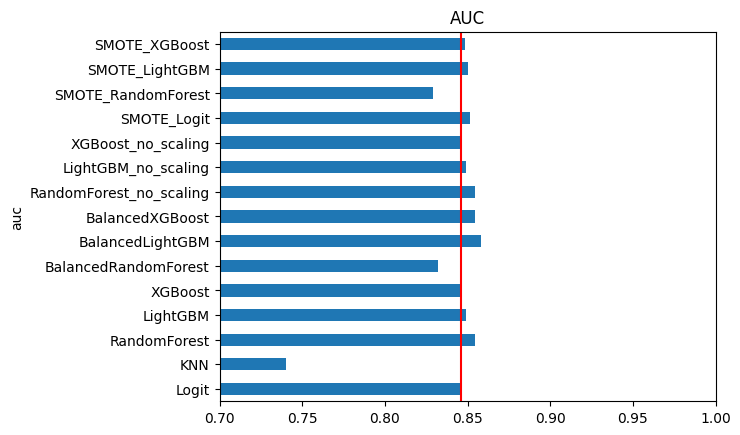

In [2149]:
pd.Series(results_dict).plot.barh()
plt.title('AUC')
plt.ylabel('auc')
plt.axvline(results_dict['Logit'], color='r')
plt.xlim([0.7, 1])
plt.show()

The Best performance is obtained with Balanced *LightGBM*. It also has very low overfitting.

---

## Hyperparameter tuning

We'll use the Balanced *LightGBM* for the next steps.

We'll perform the tuning using Randomized Search combined with Stratified Kfold cross validation (Stratified K-Fold is preserving the percentage of samples for each class)

---

In [2150]:
random_grid = {'num_leaves': list(range(5, 25)),
               'learning_rate':[0.01, 0.05, 0.1, 0.2, 0.4],
               'reg_alpha': [0, 1e-1, 1, 2, 5],
               'colsample_bytree': [0.4,0.5, 0.6,0.7, 0.8, 0.9],
               'subsample': [0.4,0.5, 0.6,0.7, 0.8, 0.9],
               'max_depth': list(range(1,10)),
               'n_estimators': list(range(10, 30))
              }

In [2151]:
model = lgbm.LGBMClassifier(
        random_state=42,
        scale_pos_weight=imb_weight
    )

In [2152]:
from sklearn.model_selection import RandomizedSearchCV

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

m_search = RandomizedSearchCV(estimator = model, 
                               param_distributions = random_grid,
                               n_iter = 1000, 
                               cv = skf, 
                               verbose=2, 
                               random_state=42,
                               refit=True,
                               n_jobs = -1)

m_search.fit(X_train, y_train)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=LGBMClassifier(random_state=42,
                                            scale_pos_weight=2.321033210332103),
                   n_iter=1000, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.4, 0.5, 0.6, 0.7,
                                                             0.8, 0.9],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2,
                                                          0.4],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8,
                                                      9],
                                        'n_estimators': [10, 11, 12, 13, 14, 15,
                                                         16, 17, 18, 19, 20, 21,
                                                         22, 23, 24, 25, 26, 27,
                                                         28, 29],
                                        'num_leaves': [5, 6, 7, 8, 9, 10, 11,
                                                       12, 13, 14, 15, 16, 17,
                                                       18, 19, 20, 21, 22, 23,
                                                       24],
                                        'reg_alpha': [0, 0.1, 1, 2, 5],
                                        'subsample': [0.4, 0.5, 0.6, 0.7, 0.8,
                                                      0.9]},
                   random_state=42, verbose=2)

In [2153]:
print ('Best Parameters: ', m_search.best_params_)

Best Parameters:  {'subsample': 0.9, 'reg_alpha': 0, 'num_leaves': 24, 'n_estimators': 17, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.4}


In [2154]:
model = lgbm.LGBMClassifier(random_state=42,
                       scale_pos_weight=imb_weight,
                       **m_search.best_params_, ) 

model.fit(X_train, y_train) 

LGBMClassifier(colsample_bytree=0.4, learning_rate=0.05, max_depth=5,
               n_estimators=17, num_leaves=24, random_state=42, reg_alpha=0,
               scale_pos_weight=2.321033210332103, subsample=0.9)

In [2155]:
train_preds = model.predict_proba(X_train)[:, 1]
test_preds = model.predict_proba(X_test)[:, 1]

print('Train AUC: ', roc_auc_score(y_train, train_preds))
print('Test AUC: ', roc_auc_score(y_test, test_preds))

Train AUC:  0.905109146480972
Test AUC:  0.8931520155415249


---

## ROC AUC

---

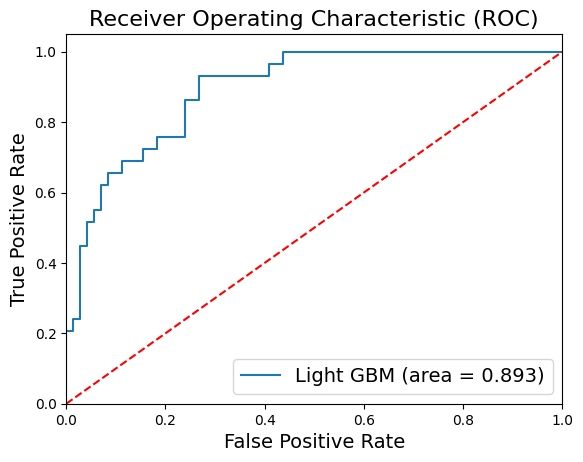

In [2156]:
from sklearn.metrics import roc_curve

rf_roc_auc = roc_auc_score(y_test, test_preds)
fpr, tpr, thresholds = roc_curve(y_test, test_preds)
plt.figure()
plt.plot(fpr, tpr, label='Light GBM (area = %0.3f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC)', fontsize=16)
plt.legend(loc="lower right", fontsize=14)
plt.show();

---

## Feature Importance


Let's look at feature importance with Shap values.

---

In [2157]:
import shap
shap.initjs()

%time
samples = X_train

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(samples, approximate=False, check_additivity=False)

CPU times: total: 0 ns
Wall time: 0 ns


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [2158]:
def make_shap_waterfall_plot(shap_values, features, num_display=20):
    
    '''
    A function for building a SHAP waterfall plot.
    
    SHAP waterfall plot is used to visualize the most important features in a descending order.
    
    Parameters:
    shap_values (list): SHAP values obtained from a model
    features (pandas DataFrame): a list of features used in a model
    num_display(int): number of features to display
    
    Returns:
    matplotlib.pyplot plot: SHAP waterfall plot
    
    '''
    
    column_list = features.columns
    feature_ratio = (np.abs(shap_values).sum(0) / np.abs(shap_values).sum()) * 100
    column_list = column_list[np.argsort(feature_ratio)[::-1]]
    feature_ratio_order = np.sort(feature_ratio)[::-1]
    cum_sum = np.cumsum(feature_ratio_order)
    column_list = column_list[:num_display]
    feature_ratio_order = feature_ratio_order[:num_display]
    cum_sum = cum_sum[:num_display]
    
    num_height = 0
    if (num_display >= 20) & (len(column_list) >= 20):
        num_height = (len(column_list) - 20) * 0.4
        
    fig, ax1 = plt.subplots(figsize=(8, 8 + num_height))
    ax1.plot(cum_sum[::-1], column_list[::-1], c='blue', marker='o')
    ax2 = ax1.twiny()
    ax2.barh(column_list[::-1], feature_ratio_order[::-1], alpha=0.6)
    
    ax1.grid(True)
    ax2.grid(False)
    ax1.set_xticks(np.arange(0, round(cum_sum.max(), -1)+1, 10))
    ax2.set_xticks(np.arange(0, round(feature_ratio_order.max(), -1)+1, 10))
    ax1.set_xlabel('Cumulative Ratio')
    ax2.set_xlabel('Composition Ratio')
    ax1.tick_params(axis="y", labelsize=13)
    plt.ylim(-1, len(column_list))

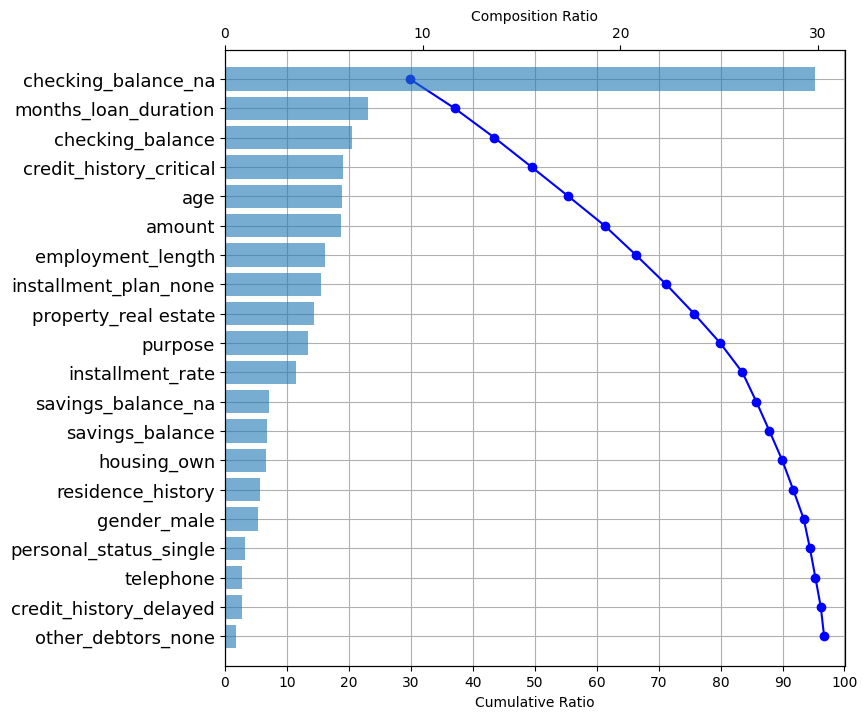

In [2159]:
# Shap waterfall plot
make_shap_waterfall_plot(shap_values[1], samples)

The presence of checking balance is a strong factor for default prediction.

---

## Feature Selection

Our model currently has 35 variables. We can try to simplify it using a feature selection method.

We will use Recursive Feature Elimination.

---

In [2160]:
from feature_engine.selection import SelectByShuffling

sel = SelectByShuffling(
    variables=None, # automatically examine all numerical variables
    estimator=model, # the ML model
    scoring='roc_auc', # the metric to evaluate
    threshold=0.0005, # the maximum performance drop allowed to select the feature
    cv=3, # cross validation
    random_state=42 # seed
)

sel.fit(X_train, y_train)

X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

In [2161]:
sel.features_to_drop_

['existing_credits',
 'dependents',
 'employment_length_na',
 'foreign_worker_yes',
 'gender_male',
 'personal_status_single',
 'personal_status_Missing',
 'personal_status_married',
 'other_debtors_none',
 'other_debtors_guarantor',
 'housing_for free',
 'job_skilled employee',
 'job_unskilled resident',
 'job_mangement self-employed',
 'credit_history_repaid',
 'credit_history_delayed',
 'property_other',
 'installment_plan_bank']

In [2162]:
len(sel.features_to_drop_)

18

In [2163]:
model.fit(X_train, y_train)

# predictions
train_preds = model.predict_proba(X_train)[:, 1]
test_preds = model.predict_proba(X_test)[:, 1]

print('Train AUC: ', roc_auc_score(y_train, train_preds))
print('Test AUC: ', roc_auc_score(y_test, test_preds))

Train AUC:  0.8941856986137429
Test AUC:  0.8727537639630889


Our model has now 17 features only with limited reduction in performance.

CPU times: total: 0 ns
Wall time: 0 ns


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


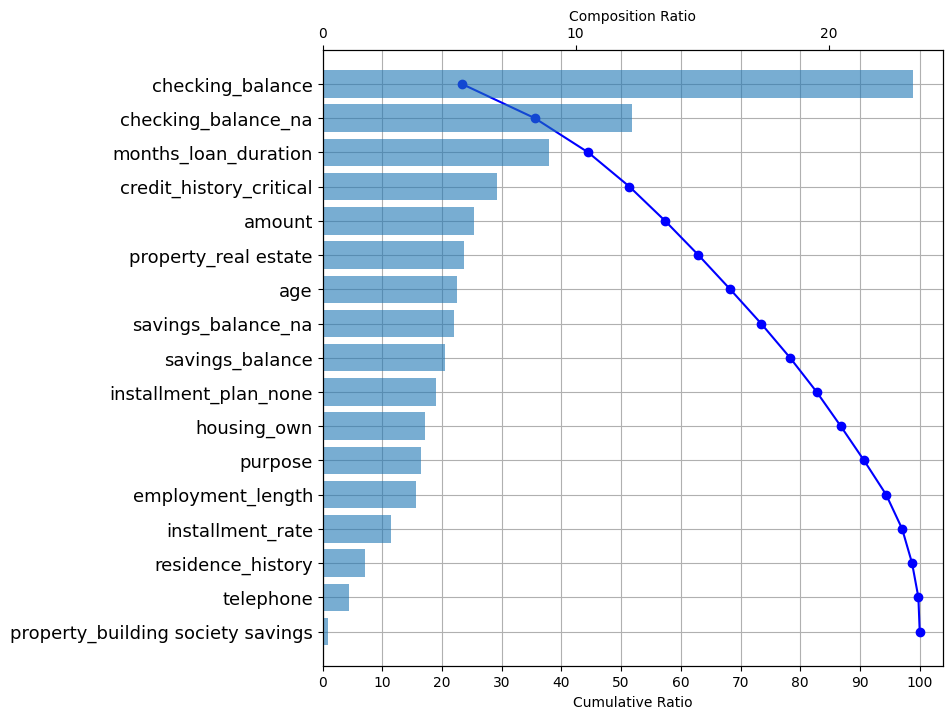

In [2164]:
# shap.initjs()
%time
samples = X_train

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(samples, approximate=False, check_additivity=False)

# Shapp waterfall plot
make_shap_waterfall_plot(shap_values[1], samples)